# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [34]:
# Repo paths (works even when notebook is in scripts/)
# We resolve the repo root by walking upward until we find the data folder.
from pathlib import Path


def find_repo_root(start=None):
    # Use current working directory by default to make notebook execution location-agnostic.
    start = Path.cwd() if start is None else Path(start)
    # Walk up the tree to find the project root that contains data/.
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    # Fallback to starting path if we cannot find the marker folder.
    return start


# Core paths used throughout the notebook so file IO is consistent.
ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
# Create plots directory so later saves do not fail.
PLOTS.mkdir(exist_ok=True)


In [35]:
# Data/ML stack used in the notebook.
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook

# Models and metrics (XGBoost and sklearn utilities).
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance

# Plotting and warnings control for cleaner notebook output.
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    'ignore',
    message=r'`sklearn\\.utils\\.parallel\\.delayed` should be used with `sklearn\\.utils\\.parallel\\.Parallel`',
    category=UserWarning,
)


In [36]:
# Re-establish repo paths so this cell can run independently.
from pathlib import Path
from typing import Optional


def find_repo_root(start: Optional[Path] = None) -> Path:
    # Resolve to an absolute path and walk upward to find the data/ folder.
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    # Fallback to the current path if the marker folder is missing.
    return p


# Canonical project paths used for input/output.
ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)


def resolve_input(filename: str) -> Path:
    # Prefer data/raw, then data/processed, then repo root for backward compatibility.
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    # Raise a helpful error if we cannot find the file anywhere expected.
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [37]:
# Load prebuilt master data.
master_path = resolve_input("master.csv")
# Parse timestamps and index the dataframe for time series operations.
df = pd.read_csv(master_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
print("Loaded", master_path, "with", len(df), "rows")


Loaded C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master.csv with 16682 rows


In [38]:
# Dynamic feature extraction for continuous anchor->current simulation.
master_df = df.copy().sort_index()

# Exclude problematic period from cutoff onward so flagged intervals are not used.
exclude_from_ts = pd.Timestamp('2025-09-18 15:10:00')
master_df = master_df.loc[master_df.index < exclude_from_ts].copy()
print('Excluded data from', exclude_from_ts, 'forward. Remaining rows:', len(master_df))

# Fertilizer dose columns used across rolling windows.
FERT_DOSE_COLS = [
    'Ammonium Nitrate [mg] -NH4NO3',
    'Monopotassium Phosphate[mg] -KH2PO4',
    'Potassium Chloride[mg] - KCL',
    'Phosphoric acid[mg]-H3PO4',
    'Kortin [mg]',
    'Gypsum - CaSO4*2H2O [mg]',
]


def _to_num(series, default=0.0):
    return pd.to_numeric(series, errors='coerce').fillna(default)


def _sum_available(frame: pd.DataFrame, cols: list) -> float:
    use_cols = [c for c in cols if c in frame.columns]
    if not use_cols:
        return 0.0
    return float(frame[use_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).sum().sum())


def _get_fert_any(frame: pd.DataFrame) -> pd.Series:
    if 'fertilization_flag' in frame.columns:
        return _to_num(frame['fertilization_flag'])

    has_a = 'fertilization_type_a_flag' in frame.columns
    has_b = 'fertilization_type_b_flag' in frame.columns
    if has_a or has_b:
        fert_a = _to_num(frame['fertilization_type_a_flag']) if has_a else pd.Series(0.0, index=frame.index)
        fert_b = _to_num(frame['fertilization_type_b_flag']) if has_b else pd.Series(0.0, index=frame.index)
        return ((fert_a > 0) | (fert_b > 0)).astype(float)

    return pd.Series(0.0, index=frame.index)


def get_features_for_row(master_df: pd.DataFrame, anchor_idx: pd.Timestamp, current_idx: pd.Timestamp) -> Dict[str, float]:
    t0 = pd.Timestamp(anchor_idx)
    t1 = pd.Timestamp(current_idx)
    if t1 < t0:
        raise ValueError(f'current_idx {t1} is earlier than anchor_idx {t0}')

    anchor_row = master_df.loc[t0]
    ph0 = float(anchor_row['ph'])
    ec0 = float(anchor_row['ec_ms'])
    gap_hours = float((t1 - t0).total_seconds() / 3600.0)

    seg = master_df.loc[t0:t1]
    w1 = master_df.loc[t1 - timedelta(hours=1):t1]
    w8 = master_df.loc[t1 - timedelta(hours=8):t1]
    w16 = master_df.loc[t1 - timedelta(hours=16):t1]
    w24 = master_df.loc[t1 - timedelta(hours=24):t1]

    # Time encoding for periodicity + day/night regime.
    hour_float = t1.hour + t1.minute / 60.0
    hour_sin = float(np.sin(2 * np.pi * hour_float / 24.0))
    hour_cos = float(np.cos(2 * np.pi * hour_float / 24.0))
    is_daytime = float(1.0 if 6 <= t1.hour < 18 else 0.0)

    # 1-hour micro windows.
    irr_ml_sum_1h = float(_to_num(w1['irrigation_ml_current']).sum()) if 'irrigation_ml_current' in w1.columns else 0.0
    fert_dose_sum_1h = _sum_available(w1, FERT_DOSE_COLS)
    rad_sum_1h = float(_to_num(w1['internal_radiation']).sum()) if 'internal_radiation' in w1.columns else 0.0
    if 'internal_air_temp_c' in w1.columns:
        temp_1h = _to_num(w1['internal_air_temp_c'])
        temp_trend_1h = float(temp_1h.iloc[-1] - temp_1h.iloc[0]) if len(temp_1h) >= 2 else 0.0
    else:
        temp_trend_1h = 0.0
    if 'irrigation_ml_current' in master_df.columns:
        irr_now = float(_to_num(pd.Series([master_df.loc[t1, 'irrigation_ml_current']])).iloc[0])
        is_irrigating_now = float(1.0 if irr_now > 0 else 0.0)
    else:
        is_irrigating_now = 0.0

    # Rolling fertilizer and irrigation windows used by the selected model features.
    fert_dose_sum_8h = _sum_available(w8, FERT_DOSE_COLS)
    fert_dose_sum_16h = _sum_available(w16, FERT_DOSE_COLS)
    fert_dose_sum_24h = _sum_available(w24, FERT_DOSE_COLS)

    irr_ml_sum_8h = float(_to_num(w8['irrigation_ml_current']).sum()) if 'irrigation_ml_current' in w8.columns else 0.0
    irr_ml_sum_16h = float(_to_num(w16['irrigation_ml_current']).sum()) if 'irrigation_ml_current' in w16.columns else 0.0
    irr_ml_sum_24h = float(_to_num(w24['irrigation_ml_current']).sum()) if 'irrigation_ml_current' in w24.columns else 0.0

    fert_x_ph0_24h = float(fert_dose_sum_24h * ph0)
    fert_x_irrig_24h = float(fert_dose_sum_24h * irr_ml_sum_24h)
    fert_per_ec0_24h = float(fert_dose_sum_24h / (ec0 + 1e-3))

    # Interval climate features (anchor -> current).
    internal_rh_mean = float(_to_num(seg['internal_rh_%']).mean()) if 'internal_rh_%' in seg.columns else 0.0
    if 'internal_air_temp_c' in seg.columns:
        tseg = _to_num(seg['internal_air_temp_c'])
        internal_air_temp_mean = float(tseg.mean())
        internal_air_temp_delta = float(tseg.iloc[-1] - tseg.iloc[0]) if len(tseg) >= 2 else 0.0
    else:
        internal_air_temp_mean = 0.0
        internal_air_temp_delta = 0.0

    et0_sum = float(_to_num(seg['ET0']).sum()) if 'ET0' in seg.columns else 0.0
    ET0_sum_per_hour = float(et0_sum / gap_hours) if gap_hours > 0 else 0.0

    soil_temp_mean = float(_to_num(seg['soil_temp_pred']).mean()) if 'soil_temp_pred' in seg.columns else 0.0
    soil_temp_mean_24h = float(_to_num(w24['soil_temp_pred']).mean()) if 'soil_temp_pred' in w24.columns else 0.0

    # Event recency at t1.
    if 'irrigation_ml_current' in master_df.columns:
        irr_hist = _to_num(master_df.loc[:t1, 'irrigation_ml_current'])
        irr_idx = irr_hist[irr_hist > 0].index
        hrs_since_last_irrig_t1 = float((t1 - irr_idx.max()).total_seconds() / 3600.0) if len(irr_idx) > 0 else np.nan
    else:
        hrs_since_last_irrig_t1 = np.nan

    fert_hist = _get_fert_any(master_df.loc[:t1])
    fert_idx = fert_hist[fert_hist > 0].index
    hours_since_last_fert_t1 = float((t1 - fert_idx.max()).total_seconds() / 3600.0) if len(fert_idx) > 0 else np.nan

    return {
        'ph0': ph0,
        'ec0': ec0,
        'gap_hours': gap_hours,
        'hour_sin': hour_sin,
        'hour_cos': hour_cos,
        'is_daytime': is_daytime,
        'irr_ml_sum_1h': irr_ml_sum_1h,
        'fert_dose_sum_1h': fert_dose_sum_1h,
        'rad_sum_1h': rad_sum_1h,
        'temp_trend_1h': temp_trend_1h,
        'is_irrigating_now': is_irrigating_now,
        'irr_ml_sum_8h': irr_ml_sum_8h,
        'irr_ml_sum_16h': irr_ml_sum_16h,
        'irr_ml_sum_24h': irr_ml_sum_24h,
        'fert_dose_sum_8h': fert_dose_sum_8h,
        'fert_dose_sum_16h': fert_dose_sum_16h,
        'fert_dose_sum_24h': fert_dose_sum_24h,
        'fert_x_ph0_24h': fert_x_ph0_24h,
        'fert_x_irrig_24h': fert_x_irrig_24h,
        'fert_per_ec0_24h': fert_per_ec0_24h,
        'internal_rh_%_mean_t0_t1': internal_rh_mean,
        'internal_air_temp_c_mean_t0_t1': internal_air_temp_mean,
        'internal_air_temp_c_delta_t0_t1': internal_air_temp_delta,
        'ET0_sum_per_hour': ET0_sum_per_hour,
        'hrs_since_last_irrig_t1': hrs_since_last_irrig_t1,
        'hours_since_last_fert_t1': hours_since_last_fert_t1,
        'soil_temp_mean': soil_temp_mean,
        'soil_temp_mean_24h': soil_temp_mean_24h,
    }


# Keep a diagnostic anchor-interval dataset for EDA only (not used for model pretraining).
sensor_rows = master_df[master_df['ph'].notna() & master_df['ec_ms'].notna()]
if len(sensor_rows) < 2:
    raise RuntimeError('Need at least 2 rows with both pH and EC for interval diagnostics.')

diag_rows = []
sensor_idx = list(sensor_rows.index)
for j in range(1, len(sensor_idx)):
    anchor_idx = sensor_idx[j - 1]
    current_idx = sensor_idx[j]
    feats = get_features_for_row(master_df, anchor_idx, current_idx)
    ph_true = float(master_df.loc[current_idx, 'ph'])
    ec_true = float(master_df.loc[current_idx, 'ec_ms'])
    feats.update({
        't_anchor': anchor_idx,
        'ph_true': ph_true,
        'ec_true': ec_true,
        'dph': ph_true - feats['ph0'],
        'dec': ec_true - feats['ec0'],
    })
    diag_rows.append((current_idx, feats))

ds = pd.DataFrame([r[1] for r in diag_rows], index=[r[0] for r in diag_rows]).sort_index()
print('Built diagnostic ds:', len(ds), '| features:', len([c for c in ds.columns if c not in ['t_anchor', 'ph_true', 'ec_true', 'dph', 'dec']]))
display(ds.head())

Excluded data from 2025-09-18 15:10:00 forward. Remaining rows: 16213
Built diagnostic ds: 100 | features: 28


,ph0,ec0,gap_hours,hour_sin,hour_cos,is_daytime,irr_ml_sum_1h,fert_dose_sum_1h,rad_sum_1h,temp_trend_1h,...,ET0_sum_per_hour,hrs_since_last_irrig_t1,hours_since_last_fert_t1,soil_temp_mean,soil_temp_mean_24h,t_anchor,ph_true,ec_true,dph,dec
2025-06-29 12:10:00,6.71,0.290,408.333333,-0.043619,-0.999048,1.0,0.000000,0.000000,5635.34890,-0.422180,...,1.067438,2.166667,72.666667,27.525716,28.924454,2025-06-12 11:50:00,8.20,0.290,1.49,0.000
2025-07-07 11:00:00,8.20,0.290,190.833333,0.258819,-0.965926,1.0,100.000000,335.500000,3781.80932,0.002667,...,1.029084,0.000000,0.000000,29.250217,29.390905,2025-06-29 12:10:00,7.11,0.361,-1.09,0.071
2025-07-16 14:00:00,7.11,0.361,219.000000,-0.500000,-0.866025,1.0,233.333333,0.000000,4666.02440,-0.322509,...,1.059638,0.500000,5.000000,29.255402,28.900302,2025-07-07 11:00:00,6.75,0.387,-0.36,0.026
2025-07-20 12:50:00,6.75,0.387,94.833333,-0.216440,-0.976296,1.0,100.000000,325.566437,5414.13900,-0.373656,...,1.032018,0.000000,0.000000,30.071080,29.663553,2025-07-16 14:00:00,6.86,0.520,0.11,0.133
2025-07-23 11:30:00,6.86,0.520,70.666667,0.130526,-0.991445,1.0,100.000000,325.566437,4984.92654,-0.048896,...,0.993500,0.166667,0.166667,29.872846,30.372106,2025-07-20 12:50:00,6.81,0.325,-0.05,-0.195


Master data rows: 16682 cols: 19
Date range: 2025-05-29 01:00:00 -> 2025-09-21 21:10:00


,missing_frac
ec_ms,0.993466
ph,0.993466
soil_temp_pred,0.000540
Kortin [mg],0.000000
Phosphoric acid[mg]-H3PO4,0.000000
Potassium Chloride[mg] - KCL,0.000000
Monopotassium Phosphate[mg] -KH2PO4,0.000000
Ammonium Nitrate [mg] -NH4NO3,0.000000
days_after_planting,0.000000
canopy_cover,0.000000


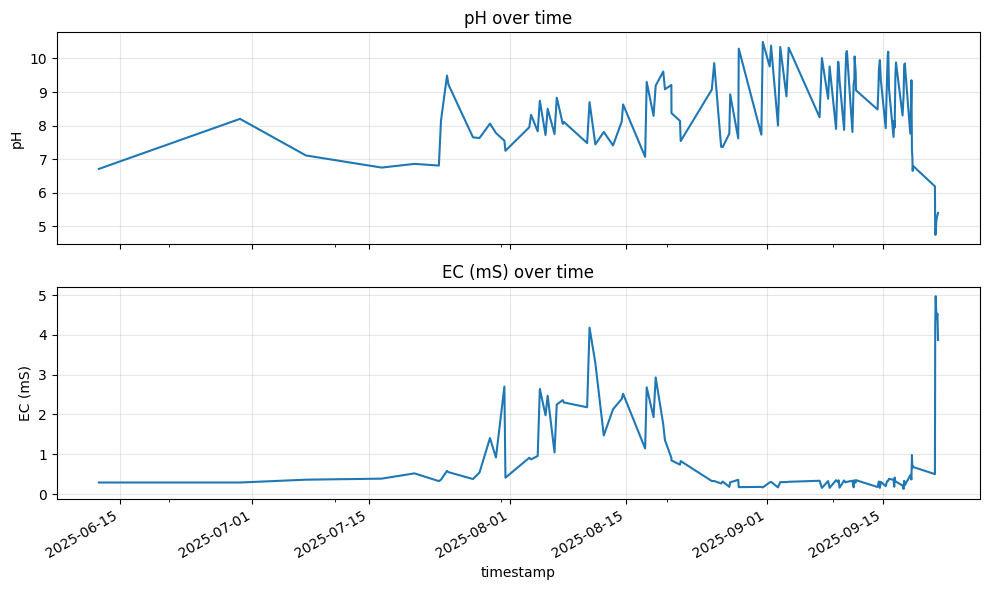

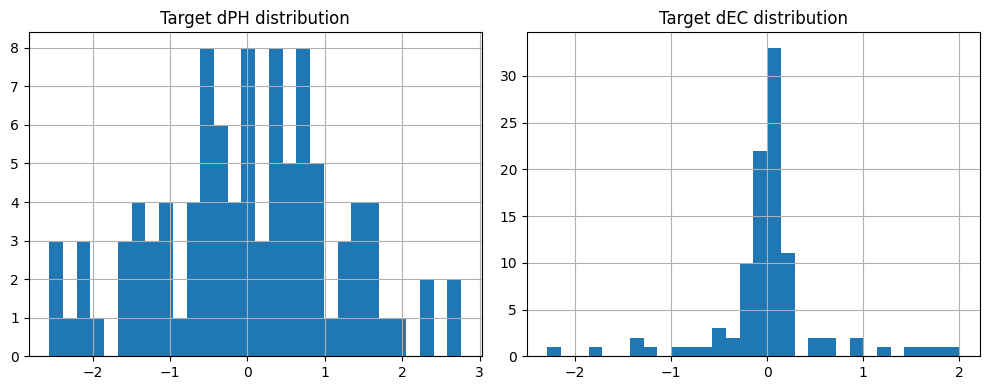

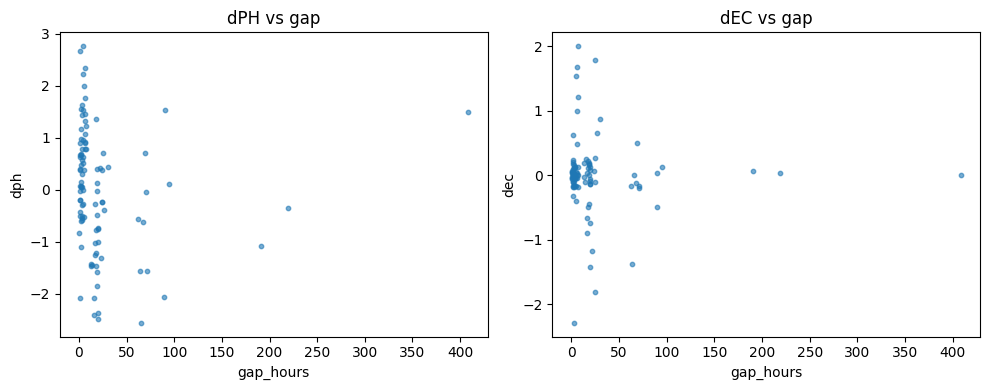

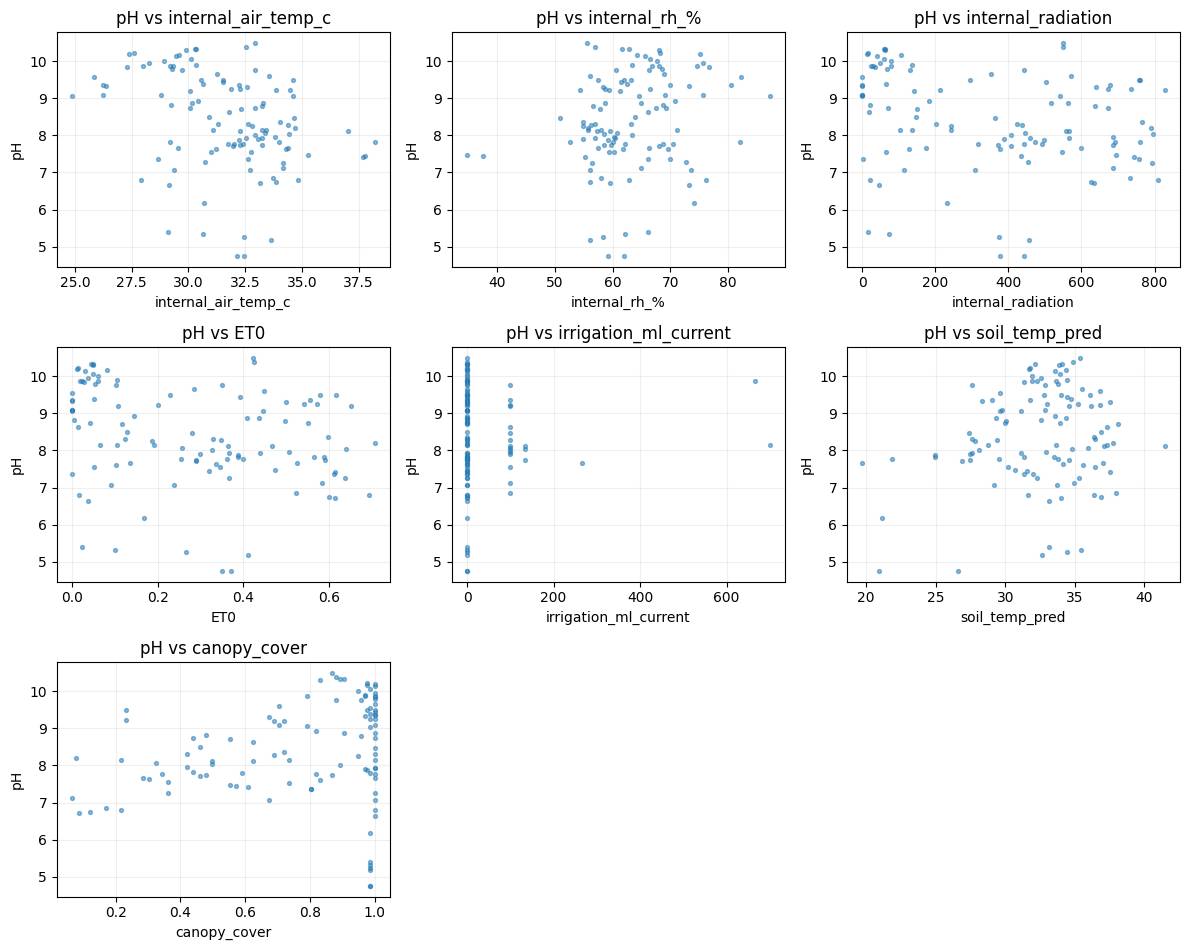

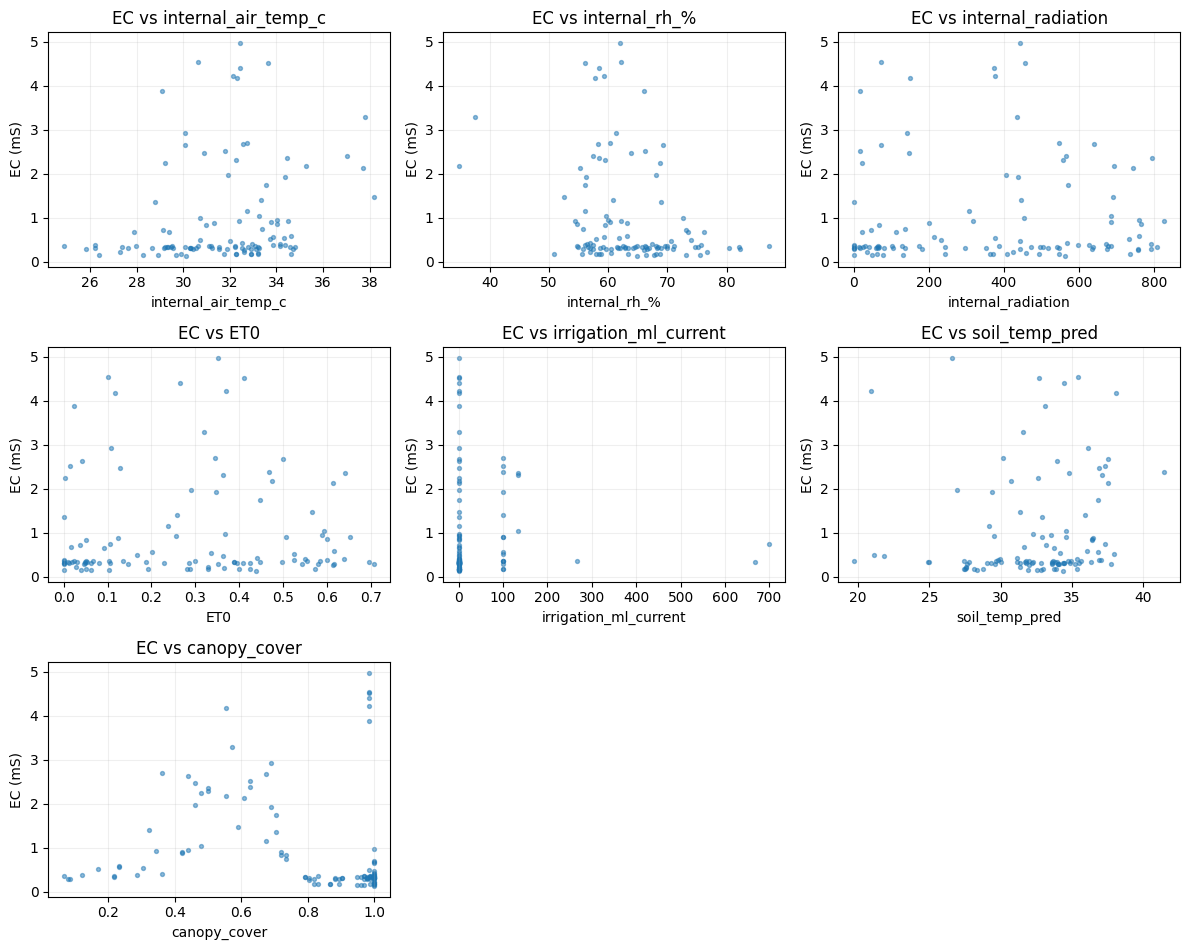

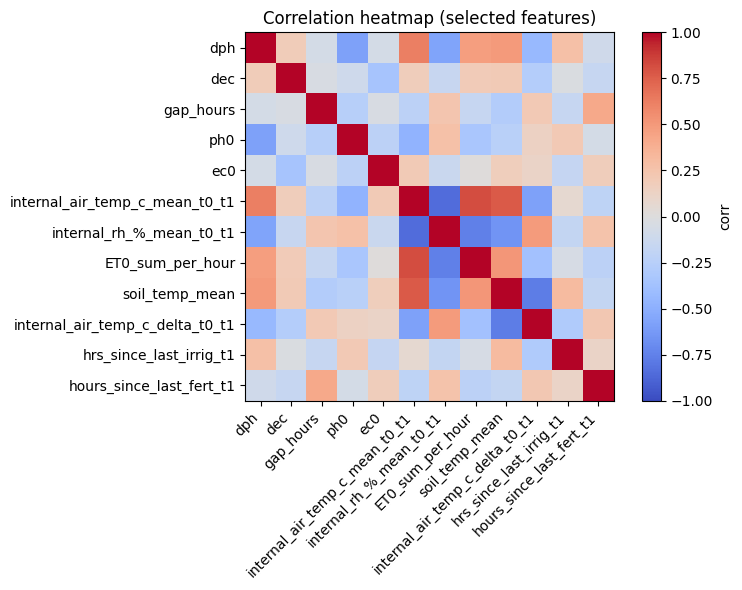

In [39]:
# Quick visuals before modeling.

# Basic dataset overview helps sanity check before training.
print('Master data rows:', len(df), 'cols:', df.shape[1])
print('Date range:', df.index.min(), '->', df.index.max())
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame('missing_frac').head(12))


# Time series for core targets (plot only non-null values).
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
if 'ph' in df.columns:
    df.loc[df['ph'].notna(), 'ph'].plot(ax=ax[0], title='pH over time')
    ax[0].set_ylabel('pH')
else:
    ax[0].set_title('pH over time (missing column)')
if 'ec_ms' in df.columns:
    df.loc[df['ec_ms'].notna(), 'ec_ms'].plot(ax=ax[1], title='EC (mS) over time')
    ax[1].set_ylabel('EC (mS)')
else:
    ax[1].set_title('EC (mS) over time (missing column)')
for a in ax: a.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


# Target distributions show how heavy-tailed or skewed the targets are.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'dph' in ds.columns:
    ds['dph'].hist(ax=ax[0], bins=30)
    ax[0].set_title('Target dPH distribution')
else:
    ax[0].set_title('Target dPH distribution (missing)')
if 'dec' in ds.columns:
    ds['dec'].hist(ax=ax[1], bins=30)
    ax[1].set_title('Target dEC distribution')
else:
    ax[1].set_title('Target dEC distribution (missing)')
plt.tight_layout(); plt.show()


# Gap vs targets to see if time gaps drive stronger changes.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'gap_hours' in ds.columns and 'dph' in ds.columns:
    ax[0].scatter(ds['gap_hours'], ds['dph'], s=10, alpha=0.6)
    ax[0].set_xlabel('gap_hours'); ax[0].set_ylabel('dph'); ax[0].set_title('dPH vs gap')
else:
    ax[0].set_title('dPH vs gap (missing)')
if 'gap_hours' in ds.columns and 'dec' in ds.columns:
    ax[1].scatter(ds['gap_hours'], ds['dec'], s=10, alpha=0.6)
    ax[1].set_xlabel('gap_hours'); ax[1].set_ylabel('dec'); ax[1].set_title('dEC vs gap')
else:
    ax[1].set_title('dEC vs gap (missing)')
plt.tight_layout(); plt.show()


# pH/EC vs selected input features (scatter).
scatter_feats = ['internal_air_temp_c', 'internal_rh_%', 'internal_radiation', 'ET0', 'irrigation_ml_current', 'soil_temp_pred', 'canopy_cover']
scatter_feats = [c for c in scatter_feats if c in df.columns]
if scatter_feats:
    n = len(scatter_feats)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ph' in df.columns:
            ax.scatter(df[feat], df['ph'], s=8, alpha=0.5)
            ax.set_ylabel('pH')
        ax.set_xlabel(feat)
        ax.set_title(f'pH vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ec_ms' in df.columns:
            ax.scatter(df[feat], df['ec_ms'], s=8, alpha=0.5)
            ax.set_ylabel('EC (mS)')
        ax.set_xlabel(feat)
        ax.set_title(f'EC vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


# Correlations for a small, interpretable subset.
corr_cols = ['dph','dec','gap_hours','ph0','ec0','internal_air_temp_c_mean_t0_t1','internal_rh_%_mean_t0_t1','ET0_sum_per_hour','soil_temp_mean','internal_air_temp_c_delta_t0_t1','days_since_start','irrig_to_gap_ratio','hrs_since_last_irrig_t1','hours_since_last_fert_t1']
corr_cols = [c for c in corr_cols if c in ds.columns]
if len(corr_cols) >= 2:
    corr = ds[corr_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation heatmap (selected features)')
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.colorbar(label='corr')
    plt.tight_layout()
    plt.show()


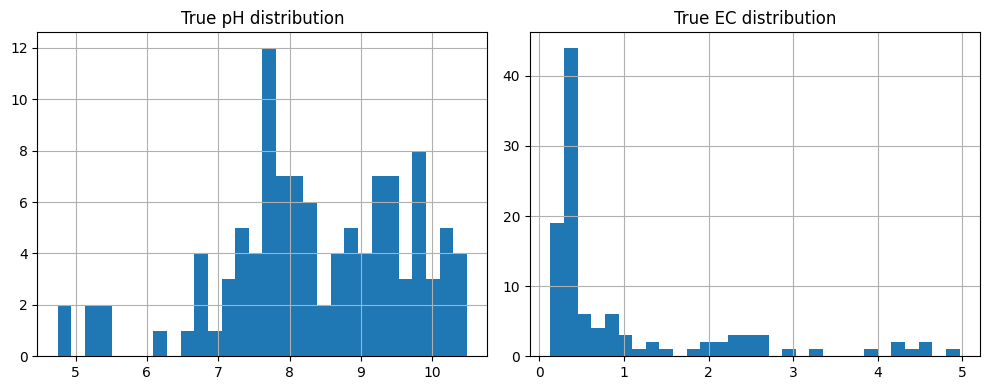

In [40]:
# Distributions of true pH/EC values (master series).
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'ph' in df.columns:
    df.loc[df['ph'].notna(), 'ph'].hist(ax=ax[0], bins=30)
    ax[0].set_title('True pH distribution')
else:
    ax[0].set_title('True pH distribution (missing)')
if 'ec_ms' in df.columns:
    df.loc[df['ec_ms'].notna(), 'ec_ms'].hist(ax=ax[1], bins=30)
    ax[1].set_title('True EC distribution')
else:
    ax[1].set_title('True EC distribution (missing)')
plt.tight_layout(); plt.show()


## Targets
This notebook uses the first 50 true pH/EC samples as warm-up training, then runs expanding walk-forward retraining while predicting continuously at each 10-minute row.

Warm-up with 50 intervals -> 50 training intervals.
Retrains during walk-forward: 50
=== Continuous Walk-Forward Metrics (Actual Rows Only) ===
PH Model MAE: 0.4762610893852333
PH Model RMSE: 0.6354135758854091
PH Naive MAE: 1.0329411764705883
PH Naive RMSE: 1.267623993239042
EC Model MAE: 0.11487808628295307
EC Model RMSE: 0.1609647637819899
EC Naive MAE: 0.10759607843137255
EC Naive RMSE: 0.1506868639941523
=== MAE Comparison by gap_bin ===


,gap_bin,count,ph_mae_model,ph_mae_naive,ec_mae_model,ec_mae_naive
0,0-12h,38,0.497719,0.841579,0.110794,0.104558
1,12-24h,11,0.470286,1.641818,0.119571,0.119655
2,24h+,2,0.101416,1.320000,0.166658,0.099000


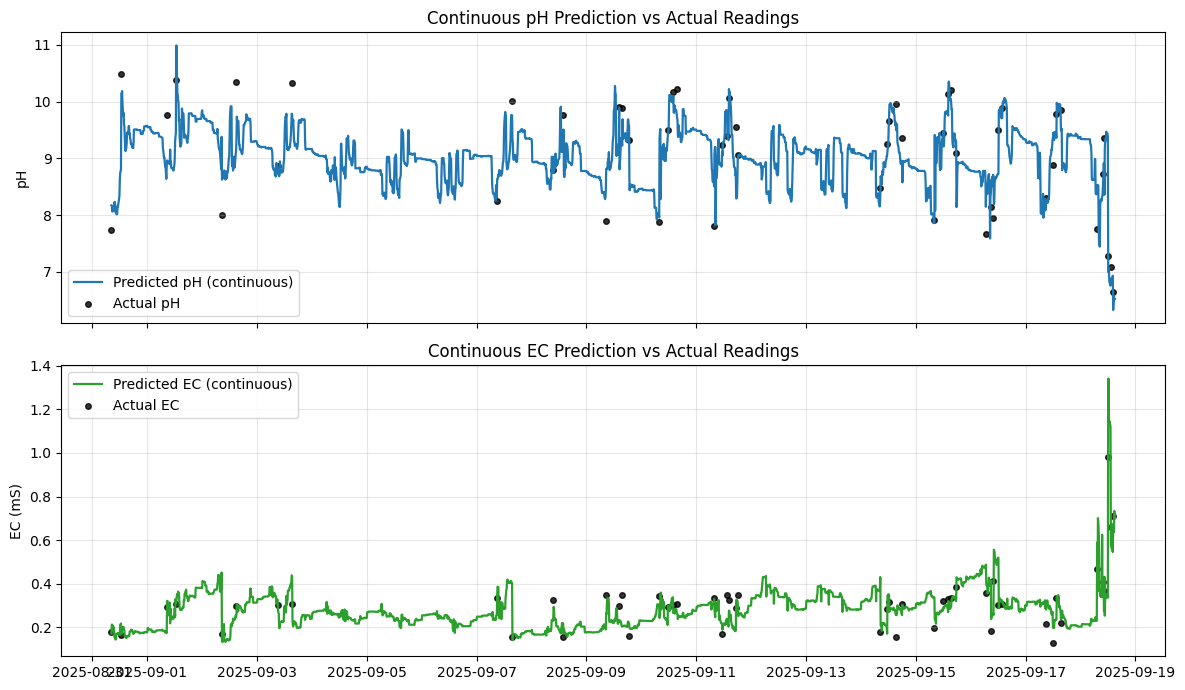

In [41]:
# Warm-up + walk-forward: first 50 true intervals for initial fit, then retrain on each new true sample.

def select_features(cols, df_ref, label):
    missing = [c for c in cols if c not in df_ref.columns]
    if missing:
        print(f"Skipping missing {label} features: {missing}")
    keep = [c for c in cols if c in df_ref.columns]
    if not keep:
        raise ValueError(f"No {label} features left after filtering.")
    return keep


feature_cols_ph = [
    'ph0','internal_rh_%_mean_t0_t1',
    'fert_dose_sum_24h',
    'fert_dose_sum_16h',
    'fert_dose_sum_8h',
    'fert_x_ph0_24h',
    'fert_x_irrig_24h',
    'irr_ml_sum_8h',
    'irr_ml_sum_16h',
    'irr_ml_sum_24h',
    'ET0_sum_per_hour',
    'hours_since_last_fert_t1',
    'hrs_since_last_irrig_t1',
    'internal_air_temp_c_mean_t0_t1',
    'soil_temp_mean',
    'ec0','internal_air_temp_c_delta_t0_t1',
    'gap_hours',
]

feature_cols_ec = [
    'ec0','soil_temp_mean',
    'ph0','ET0_sum_per_hour',
    'irr_ml_sum_24h',
    'internal_rh_%_mean_t0_t1',
    'fert_dose_sum_24h',
    'fert_dose_sum_16h',
    'fert_dose_sum_8h',
    'fert_per_ec0_24h',
    'fert_x_irrig_24h',
    'internal_air_temp_c_delta_t0_t1',
    'internal_air_temp_c_mean_t0_t1',
    'hours_since_last_fert_t1',
    'hrs_since_last_irrig_t1',
    'gap_hours','irr_ml_sum_8h',
    'irr_ml_sum_16h',
]

feature_cols_ph = select_features(feature_cols_ph, ds, 'pH')
feature_cols_ec = select_features(feature_cols_ec, ds, 'EC')

_eps = 1e-6
sensor_mask = master_df['ph'].notna() & master_df['ec_ms'].notna()
sensor_idx = list(master_df.index[sensor_mask])

warmup_train_intervals = 50
if len(sensor_idx) <= warmup_train_intervals:
    raise RuntimeError(f'Need more than {warmup_train_intervals} true pH/EC samples to build {warmup_train_intervals} warm-up intervals. Found {len(sensor_idx)}.')

# Build initial warm-up training intervals (exactly 50 intervals).
train_rows = []
for j in range(1, warmup_train_intervals + 1):
    t_anchor = sensor_idx[j - 1]
    t_current = sensor_idx[j]
    feats = get_features_for_row(master_df, t_anchor, t_current)
    ph_true = float(master_df.loc[t_current, 'ph'])
    ec_true = float(master_df.loc[t_current, 'ec_ms'])
    train_rows.append({
        'timestamp': t_current,
        'anchor_idx': t_anchor,
        **feats,
        'ph_true': ph_true,
        'ec_true': ec_true,
    })

train_df = pd.DataFrame(train_rows).set_index('timestamp').sort_index()
print(f'Warm-up with {warmup_train_intervals} intervals -> {len(train_df)} training intervals.')


def fit_models(current_train_df: pd.DataFrame):
    X_ph = current_train_df[feature_cols_ph]
    X_ec = current_train_df[feature_cols_ec]
    y_ph = np.log((current_train_df['ph_true'] + _eps) / (current_train_df['ph0'] + _eps))
    y_ec = np.log((current_train_df['ec_true'] + _eps) / (current_train_df['ec0'] + _eps))

    xgb_params_ph = dict(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )

    xgb_params_ec = dict(
        n_estimators=600,
        learning_rate=0.02,
        max_depth=6,
        min_child_weight=5,
        subsample=0.9,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )

    ph_m = xgb.XGBRegressor(**xgb_params_ph)
    ec_m = xgb.XGBRegressor(**xgb_params_ec)
    ph_m.fit(X_ph, y_ph)
    ec_m.fit(X_ec, y_ec)
    return ph_m, ec_m


ph_model, ec_model = fit_models(train_df)

# Simulation starts at the sample immediately after the 50 warm-up intervals.
anchor_idx = sensor_idx[warmup_train_intervals]
start_idx = anchor_idx
results = []
retrain_count = 0

for current_idx in master_df.loc[start_idx:].index:
    feats = get_features_for_row(master_df, anchor_idx, current_idx)
    X_row_ph = pd.DataFrame([feats])[feature_cols_ph]
    X_row_ec = pd.DataFrame([feats])[feature_cols_ec]

    log_ph_pred = float(ph_model.predict(X_row_ph)[0])
    log_ec_pred = float(ec_model.predict(X_row_ec)[0])

    ph_pred = (feats['ph0'] + _eps) * float(np.exp(log_ph_pred)) - _eps
    ec_pred_raw = (feats['ec0'] + _eps) * float(np.exp(log_ec_pred)) - _eps
    ec_pred = max(0.0, ec_pred_raw)

    row = {
        'timestamp': current_idx,
        'anchor_idx': anchor_idx,
        'gap_hours': float(feats['gap_hours']),
        'ph0': float(feats['ph0']),
        'ec0': float(feats['ec0']),
        'ph_pred': float(ph_pred),
        'ec_pred': float(ec_pred),
        'has_actual': False,
        'ph_true': np.nan,
        'ec_true': np.nan,
        'ph_naive': np.nan,
        'ec_naive': np.nan,
        'ph_abs_error': np.nan,
        'ec_abs_error': np.nan,
        'ph_abs_error_naive': np.nan,
        'ec_abs_error_naive': np.nan,
    }

    has_actual = pd.notna(master_df.loc[current_idx, 'ph']) and pd.notna(master_df.loc[current_idx, 'ec_ms'])
    if has_actual:
        ph_true = float(master_df.loc[current_idx, 'ph'])
        ec_true = float(master_df.loc[current_idx, 'ec_ms'])

        row.update({
            'has_actual': True,
            'ph_true': ph_true,
            'ec_true': ec_true,
            'ph_naive': float(feats['ph0']),
            'ec_naive': float(feats['ec0']),
            'ph_abs_error': abs(float(ph_pred) - ph_true),
            'ec_abs_error': abs(float(ec_pred) - ec_true),
            'ph_abs_error_naive': abs(float(feats['ph0']) - ph_true),
            'ec_abs_error_naive': abs(float(feats['ec0']) - ec_true),
        })

        # Expand training set only when we get a new true point after the current anchor.
        if current_idx != anchor_idx:
            new_train_row = {
                'timestamp': current_idx,
                'anchor_idx': anchor_idx,
                **feats,
                'ph_true': ph_true,
                'ec_true': ec_true,
            }
            train_df = pd.concat([train_df, pd.DataFrame([new_train_row]).set_index('timestamp')]).sort_index()
            ph_model, ec_model = fit_models(train_df)
            retrain_count += 1
            anchor_idx = current_idx

    results.append(row)

results_df = pd.DataFrame(results).set_index('timestamp').sort_index()
pred_df = results_df.copy()
eval_df = results_df[results_df['has_actual']].copy()

if len(eval_df) == 0:
    raise RuntimeError('Simulation produced no evaluable rows with actual pH/EC values.')


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print('Retrains during walk-forward:', retrain_count)
print('=== Continuous Walk-Forward Metrics (Actual Rows Only) ===')
print('PH Model MAE:', float(mean_absolute_error(eval_df['ph_true'], eval_df['ph_pred'])))
print('PH Model RMSE:', rmse(eval_df['ph_true'], eval_df['ph_pred']))
print('PH Naive MAE:', float(mean_absolute_error(eval_df['ph_true'], eval_df['ph_naive'])))
print('PH Naive RMSE:', rmse(eval_df['ph_true'], eval_df['ph_naive']))

print('EC Model MAE:', float(mean_absolute_error(eval_df['ec_true'], eval_df['ec_pred'])))
print('EC Model RMSE:', rmse(eval_df['ec_true'], eval_df['ec_pred']))
print('EC Naive MAE:', float(mean_absolute_error(eval_df['ec_true'], eval_df['ec_naive'])))
print('EC Naive RMSE:', rmse(eval_df['ec_true'], eval_df['ec_naive']))

# Comparison by gap-hour bins.
gap_bins = [-np.inf, 12, 24, np.inf]
gap_labels = ['0-12h', '12-24h', '24h+']
eval_df['gap_bin'] = pd.cut(eval_df['gap_hours'], bins=gap_bins, labels=gap_labels, include_lowest=True)

bin_rows = []
for gap_bin, grp in eval_df.groupby('gap_bin', observed=False):
    if len(grp) == 0:
        continue
    bin_rows.append({
        'gap_bin': str(gap_bin),
        'count': int(len(grp)),
        'ph_mae_model': float(mean_absolute_error(grp['ph_true'], grp['ph_pred'])),
        'ph_mae_naive': float(mean_absolute_error(grp['ph_true'], grp['ph_naive'])),
        'ec_mae_model': float(mean_absolute_error(grp['ec_true'], grp['ec_pred'])),
        'ec_mae_naive': float(mean_absolute_error(grp['ec_true'], grp['ec_naive'])),
    })

bin_cmp_df = pd.DataFrame(bin_rows)
print('=== MAE Comparison by gap_bin ===')
display(bin_cmp_df)

# For feature importance + SHAP cells.
X_all_ph = train_df[feature_cols_ph].copy()
X_all_ec = train_df[feature_cols_ec].copy()

# Continuous prediction traces with actual points.
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(results_df.index, results_df['ph_pred'], color='tab:blue', lw=1.6, label='Predicted pH (continuous)')
ax[0].scatter(eval_df.index, eval_df['ph_true'], color='black', s=16, alpha=0.8, label='Actual pH')
ax[0].set_ylabel('pH')
ax[0].set_title('Continuous pH Prediction vs Actual Readings')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

ax[1].plot(results_df.index, results_df['ec_pred'], color='tab:green', lw=1.6, label='Predicted EC (continuous)')
ax[1].scatter(eval_df.index, eval_df['ec_true'], color='black', s=16, alpha=0.8, label='Actual EC')
ax[1].set_ylabel('EC (mS)')
ax[1].set_title('Continuous EC Prediction vs Actual Readings')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

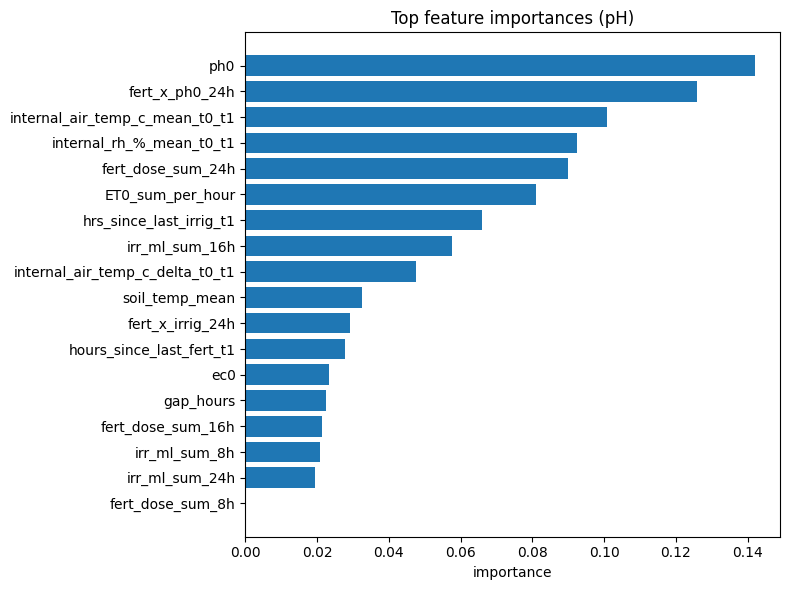

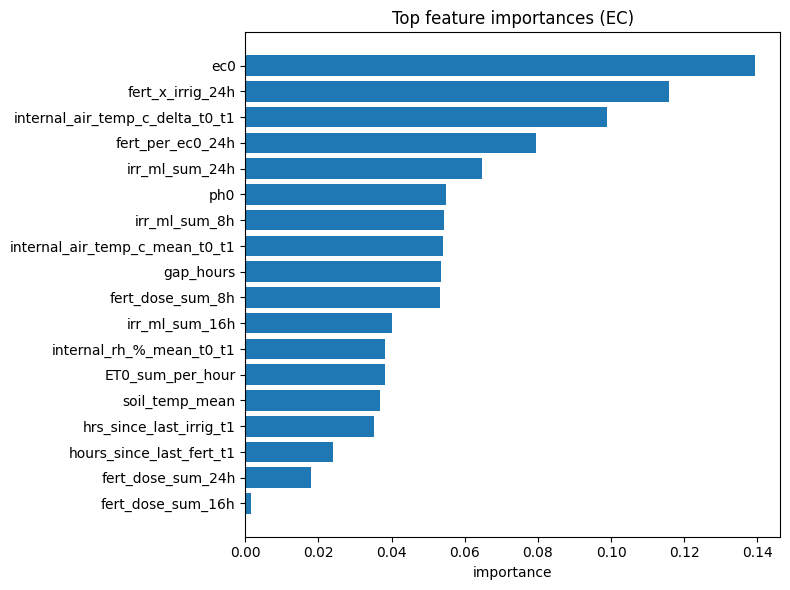

In [42]:
# Feature importance (display only) for the current feature sets.
for tgt_name, est, cols in [
    ('pH', ph_model, feature_cols_ph),
    ('EC', ec_model, feature_cols_ec),
]:
    imp = pd.Series(est.feature_importances_, index=cols).sort_values(ascending=False)
    top = imp.head(min(25, len(imp)))
    plt.figure(figsize=(8, 6))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(f'Top feature importances ({tgt_name})')
    plt.xlabel('importance')
    plt.tight_layout()
    plt.show()

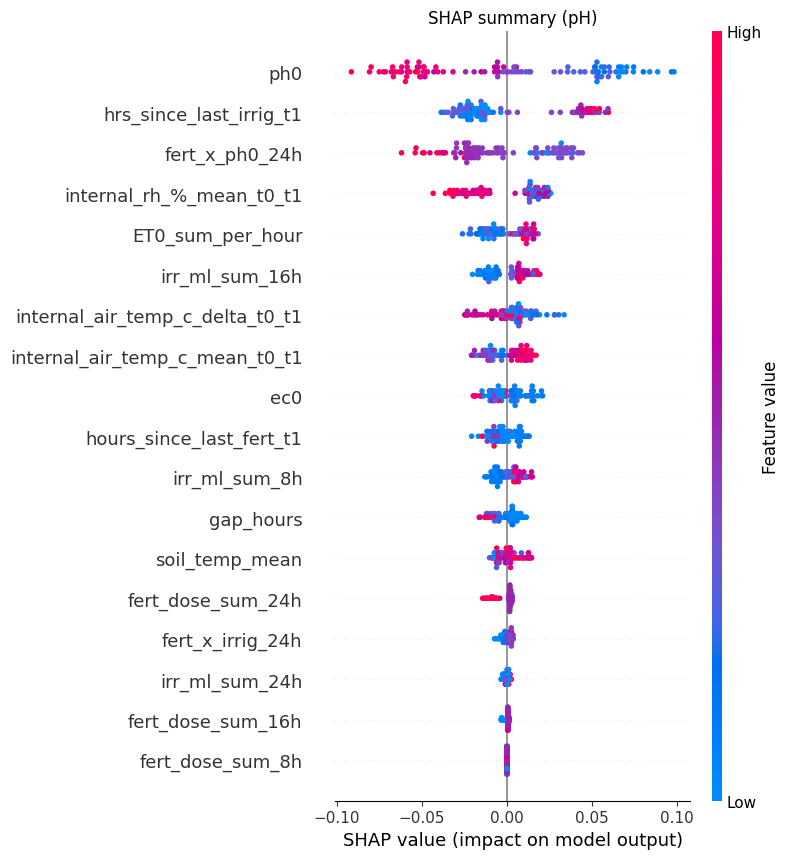

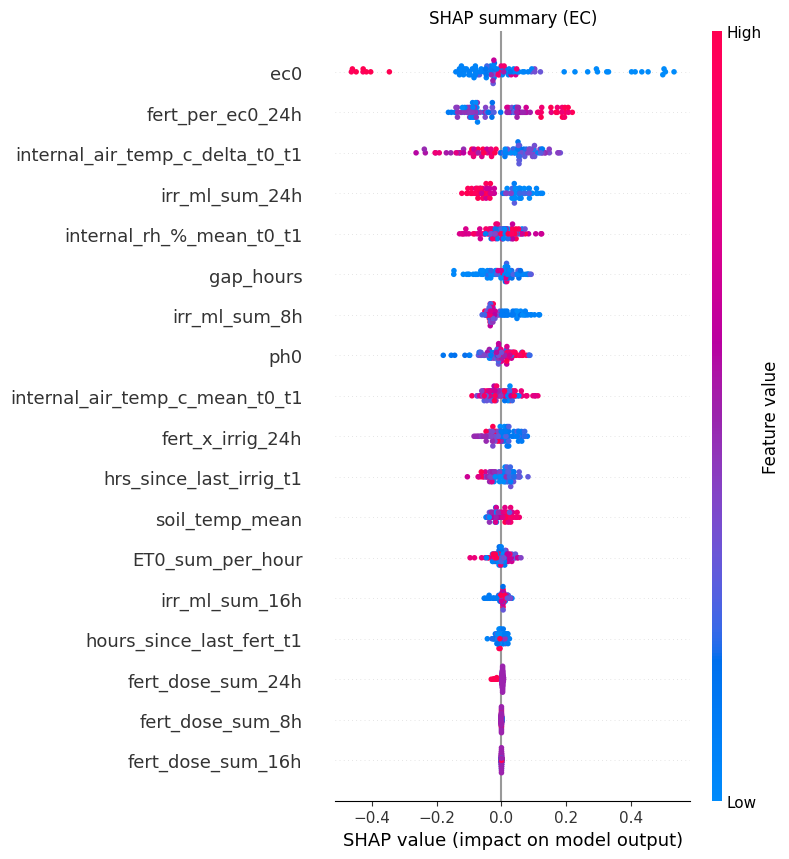

In [43]:
# SHAP summary plots (if shap is installed).
try:
    import shap
except ImportError as e:
    raise ImportError('shap is not installed in this environment. Install with: pip install shap') from e

X_sample_ph = X_all_ph.sample(n=min(300, len(X_all_ph)), random_state=42)
X_sample_ec = X_all_ec.sample(n=min(300, len(X_all_ec)), random_state=42)

for tgt_name, est, X_sample in [
    ('pH', ph_model, X_sample_ph),
    ('EC', ec_model, X_sample_ec),
]:
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP summary ({tgt_name})')
    plt.tight_layout()
    plt.show()

In [44]:
# Save continuous simulation outputs for later analysis.
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PROCESSED / 'rootzone_continuous_model_predictions.csv')
print('Saved', PROCESSED / 'rootzone_continuous_model_predictions.csv')

eval_df.to_csv(PROCESSED / 'rootzone_continuous_model_eval_actual_rows.csv')
print('Saved', PROCESSED / 'rootzone_continuous_model_eval_actual_rows.csv')

Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rootzone_continuous_model_predictions.csv
Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rootzone_continuous_model_eval_actual_rows.csv
